In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.stats import norm
plt.rcParams["figure.figsize"] = (5,4)

In [2]:
file_path = 'results/dict/'
file_name = os.listdir(file_path)

In [3]:
clip = 0.04

# Performance

## Adult

In [31]:
noise_scale = [30.0, 11.25, 5.9375, 4.140625, 3.2421875, 1.5771484375, 1.0302734375, 0.8514404296875, 0.758056640625] 
epsilon = [0.1, 0.25, 0.5, 0.75, 1.0, 2.5, 5.0, 7.5, 10.0]

In [32]:
performance = []
for ns in noise_scale:
    num_file = 0
    test_acc = 0
    for i, file in enumerate(file_name):
        if ('adult_' in file) and ('sigma_{}'.format(ns) in file) and ('proposed_' in file):
            # print(file)
            with open('{}{}'.format(file_path,file), 'rb') as f:
                res = pickle.load(f)
                test_acc += res['test_history_acc'][-1]
                num_file += 1
    performance.append(test_acc/num_file)

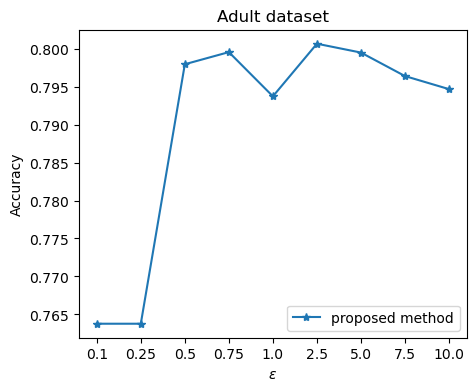

In [33]:
plt.plot(range(len(epsilon)), performance, '-*', label = 'proposed method')
# plt.plot(range(len(epsilon)), np.ones(len(epsilon))*0.8, '-o', label = 'no-DP')
plt.ylabel(r'Accuracy')
plt.xlabel(r'$\epsilon$')
plt.xticks(range(len(epsilon)), epsilon)
plt.title('Adult dataset')
plt.legend()

In [7]:
t = [norm.ppf(0.975, loc=0, scale=i*clip) for i in noise_scale]
def bound(t, clip):
    return 0.1*(2*clip+2*t)/2
bd = []
for i, n in enumerate(t):
    bd.append(bound(n, 0.04))

In [8]:
max_deviation = []
for ns in noise_scale:
    num_file = 0
    dev = 0
    for i, file in enumerate(file_name):
        if ('adult_' in file) and ('sigma_{}'.format(ns) in file) and ('clean_' not in file) and ('alg1_' not in file) and ('fair_' not in file):
            # print(file)
            with open('{}{}'.format(file_path,file), 'rb') as f:
                res = pickle.load(f)
                # print(res.keys())
                dev += max(res['male_norm'][-1], res['female_norm'][-1])
                num_file += 1
    max_deviation.append(dev/num_file)

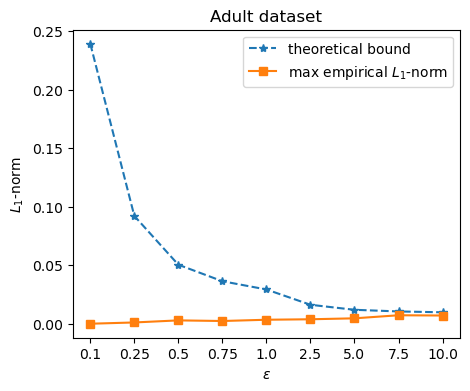

In [9]:
# eps = [0.5, 1.0, 2.0, 5.0]
plt.plot(range(len(epsilon)), bd, '--*', label='theoretical bound')
# plt.plot(range(len(epsilon)), new_bd, '--*', label='new bound')
plt.plot(range(len(epsilon)), max_deviation, '-s', label=r'max empirical $L_1$-norm')
plt.ylabel(r'$L_1$-norm')
plt.xlabel(r'$\epsilon$')
plt.title('Adult dataset')
plt.xticks(range(len(epsilon)), epsilon)
plt.legend()

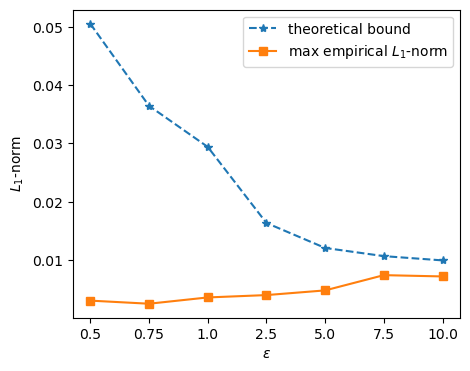

In [10]:
# eps = [0.5, 1.0, 2.0, 5.0]
plt.plot(range(len(epsilon)-2), bd[2:], '--*', label='theoretical bound')
# plt.plot(range(len(epsilon)-2), new_bd[2:], '--*', label='new bound')
plt.plot(range(len(epsilon)-2), max_deviation[2:], '-s', label=r'max empirical $L_1$-norm')
plt.ylabel(r'$L_1$-norm')
plt.xlabel(r'$\epsilon$')
plt.xticks(range(len(epsilon)-2), epsilon[2:])
plt.legend()

## Bank

In [34]:
noise_scale = [30.0, 11.25, 5.9375, 4.140625, 3.22265625, 1.5673828125, 1.025390625, 0.8477783203125, 0.758056640625] 
epsilon = [0.1, 0.25, 0.5, 0.75, 1.0, 2.5, 5.0, 7.5, 10.0]

In [35]:
performance = []
for ns in noise_scale:
    num_file = 0
    test_acc = 0
    for i, file in enumerate(file_name):
        if ('bank_' in file) and ('sigma_{}'.format(ns) in file) and ('clean_' not in file) and ('alg1_' not in file) and ('fair_' not in file):
            # print(file)
            with open('{}{}'.format(file_path,file), 'rb') as f:
                res = pickle.load(f)
                test_acc += res['test_history_acc'][-1]
                num_file += 1
    performance.append(test_acc/num_file)

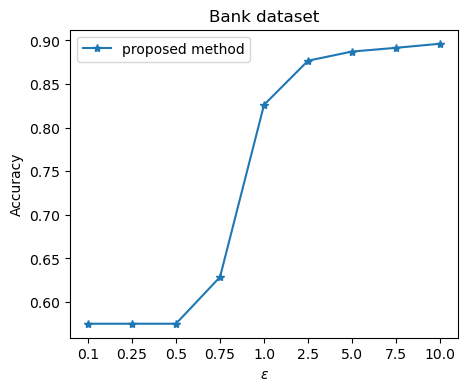

In [36]:
plt.plot(range(len(epsilon)), performance, '-*', label = 'proposed method')
# plt.plot(range(len(epsilon)), np.ones(len(epsilon))*0.89, '-o', label = 'no-DP')
plt.ylabel(r'Accuracy')
plt.xlabel(r'$\epsilon$')
plt.title('Bank dataset')
plt.xticks(range(len(epsilon)), epsilon)
plt.legend()

In [21]:
t = [norm.ppf(0.975, loc=0, scale=i*clip) for i in noise_scale]
def bound(t, clip):
    return 0.1*(2*clip+2*t)/2
bd = []
for i, n in enumerate(t):
    bd.append(bound(n, 0.04))

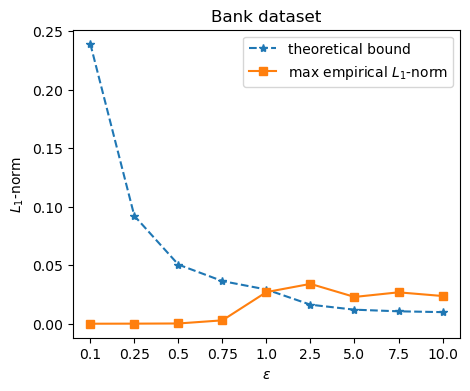

In [22]:
max_deviation = []
for ns in noise_scale:
    num_file = 0
    dev = 0
    for i, file in enumerate(file_name):
        if ('bank_' in file) and ('sigma_{}'.format(ns) in file) and ('clean_' not in file) and ('alg1_' not in file) and ('fair_' not in file):
            # print(file)
            with open('{}{}'.format(file_path,file), 'rb') as f:
                res = pickle.load(f)
                # print(res.keys())
                dev += max(res['male_norm'][-1], res['female_norm'][-1])
                num_file += 1
    max_deviation.append(dev/num_file)
# eps = [0.5, 1.0, 2.0, 5.0]
plt.plot(range(len(epsilon)), bd, '--*', label='theoretical bound')
# plt.plot(range(len(epsilon)), new_bd, '--*', label='new bound')
plt.plot(range(len(epsilon)), max_deviation, '-s', label=r'max empirical $L_1$-norm')
plt.ylabel(r'$L_1$-norm')
plt.xlabel(r'$\epsilon$')
plt.title('Bank dataset')
plt.xticks(range(len(epsilon)), epsilon)
plt.legend()

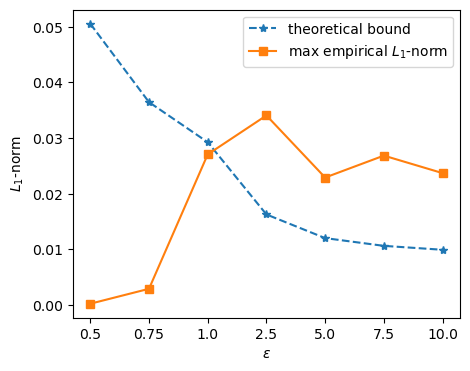

In [23]:
# eps = [0.5, 1.0, 2.0, 5.0]
plt.plot(range(len(epsilon)-2), bd[2:], '--*', label='theoretical bound')
# plt.plot(range(len(epsilon)-2), new_bd[2:], '--*', label='new bound')
plt.plot(range(len(epsilon)-2), max_deviation[2:], '-s', label=r'max empirical $L_1$-norm')
plt.ylabel(r'$L_1$-norm')
plt.xlabel(r'$\epsilon$')
plt.xticks(range(len(epsilon)-2), epsilon[2:])
plt.legend()

## Stroke

In [37]:
noise_scale = [45.0, 16.875, 8.90625, 6.171875, 4.8046875, 2.236328125, 1.3671875, 1.0791015625, 0.93292236328125] 
epsilon = [0.1, 0.25, 0.5, 0.75, 1.0, 2.5, 5.0, 7.5, 10.0]

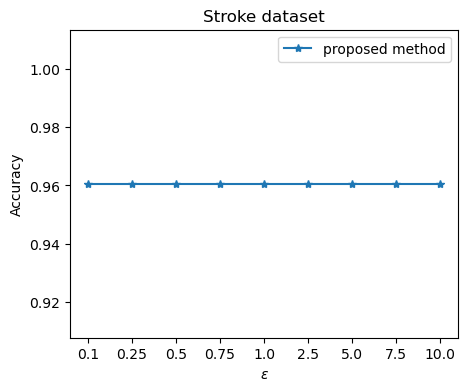

In [38]:
performance = []
for ns in noise_scale:
    num_file = 0
    test_acc = 0
    for i, file in enumerate(file_name):
        if ('stroke_' in file) and ('sigma_{}'.format(ns) in file) and ('proposed_' in file):
            with open('{}{}'.format(file_path,file), 'rb') as f:
                res = pickle.load(f)
                test_acc += res['test_history_acc'][-1]
                num_file += 1
    performance.append(test_acc/num_file)

plt.plot(range(len(epsilon)), performance, '-*', label = 'proposed method')
# plt.plot(range(len(epsilon)), np.ones(len(epsilon))*0.964, '-o', label = 'no-DP')
plt.ylabel(r'Accuracy')
plt.xlabel(r'$\epsilon$')
plt.title('Stroke dataset')
plt.xticks(range(len(epsilon)), epsilon)
plt.legend()

In [26]:
t = [norm.ppf(0.975, loc=0, scale=i*clip) for i in noise_scale]
def bound(t, clip):
    return 0.1*(2*clip+2*t)/2
bd = []
for i, n in enumerate(t):
    bd.append(bound(n, 0.04))

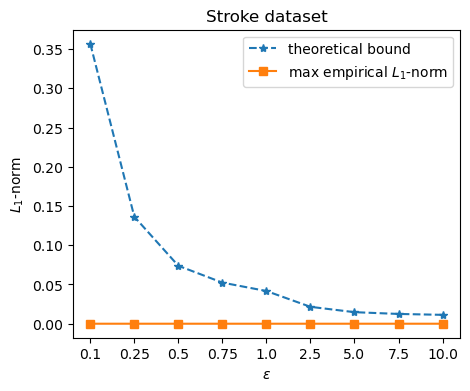

In [27]:
max_deviation = []
for ns in noise_scale:
    num_file = 0
    dev = 0
    for i, file in enumerate(file_name):
        if ('stroke_' in file) and ('sigma_{}'.format(ns) in file) and ('proposed_' in file):
            with open('{}{}'.format(file_path,file), 'rb') as f:
                res = pickle.load(f)
                # print(res.keys())
                dev += max(res['male_norm'][-1], res['female_norm'][-1])
                num_file += 1
    max_deviation.append(dev/num_file)
# eps = [0.5, 1.0, 2.0, 5.0]
plt.plot(range(len(epsilon)), bd, '--*', label='theoretical bound')
# plt.plot(range(len(epsilon)), new_bd, '--*', label='new bound')
plt.plot(range(len(epsilon)), max_deviation, '-s', label=r'max empirical $L_1$-norm')
plt.ylabel(r'$L_1$-norm')
plt.xlabel(r'$\epsilon$')
plt.title('Stroke dataset')
plt.xticks(range(len(epsilon)), epsilon)
plt.legend()

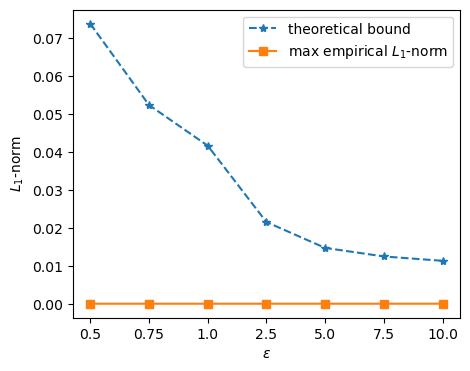

In [28]:
# eps = [0.5, 1.0, 2.0, 5.0]
plt.plot(range(len(epsilon)-2), bd[2:], '--*', label='theoretical bound')
# plt.plot(range(len(epsilon)-2), new_bd[2:], '--*', label='new bound')
plt.plot(range(len(epsilon)-2), max_deviation[2:], '-s', label=r'max empirical $L_1$-norm')
plt.ylabel(r'$L_1$-norm')
plt.xlabel(r'$\epsilon$')
plt.xticks(range(len(epsilon)-2), epsilon[2:])
plt.legend()

# Compare

## Adult

In [9]:
noise_scale = [30.0, 11.25, 5.9375, 4.140625, 3.2421875, 1.5771484375, 1.0302734375, 0.8514404296875, 0.758056640625] 
epsilon = [0.1, 0.25, 0.5, 0.75, 1.0, 2.5, 5.0, 7.5, 10.0]

t = [norm.ppf(0.975, loc=0, scale=i*clip) for i in noise_scale]
def bound(t, clip):
    return 0.1*(2*clip+2*t)/2
bd = []
for i, n in enumerate(t):
    bd.append(bound(n, 0.04))

In [10]:
with open('results/dict/adult_fair_fold_0_sigma_3.2421875_C_0.04_24112022_73515.pkl', 'rb') as f:
    run_fair_dict = pickle.load(f)
with open('results/dict/adult_proposed_fold_0_sigma_3.2421875_C_0.04_23112022_20756.pkl', 'rb') as f:
    run_proposed_dict = pickle.load(f)
with open('results/dict/adult_alg1_fold_0_sigma_3.2421875_C_0.04_24112022_73538.pkl', 'rb') as f:
    run_alg1_dict = pickle.load(f)

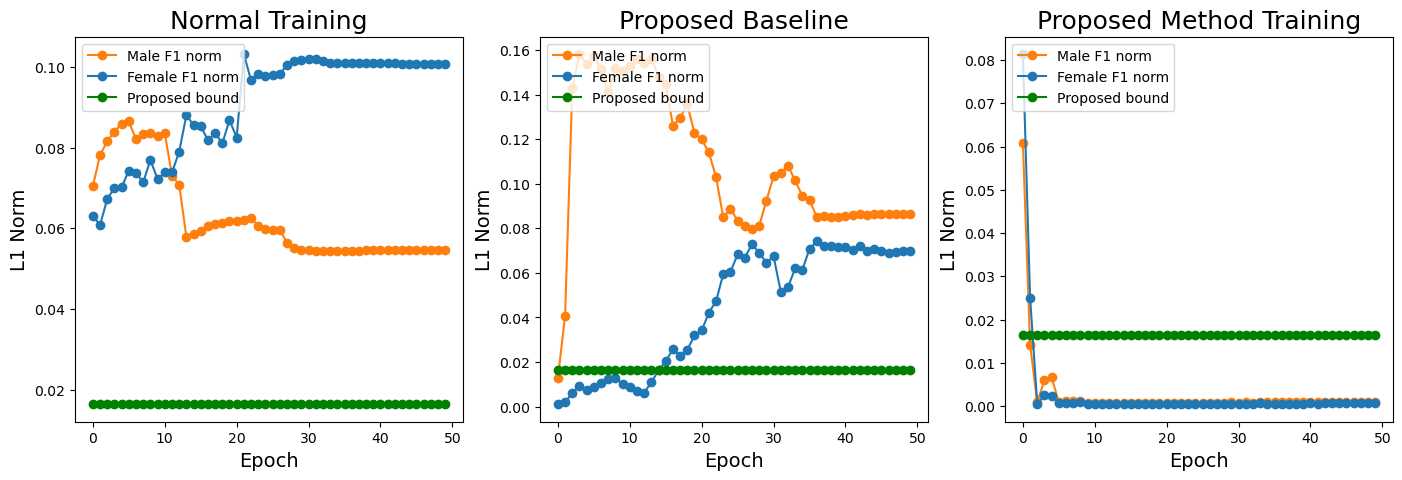

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(17,5))
b = bd[5]
axs[0].plot(
    np.arange(len(run_fair_dict['male_norm'])),
    run_fair_dict['male_norm'],
    '-o',
    label='Male F1 norm',
    color='#ff7f0e'
)

axs[0].plot(
    np.arange(len(run_fair_dict['female_norm'])),
    run_fair_dict['female_norm'],
    '-o',
    label='Female F1 norm',
    color='#1f77b4'
)

axs[0].plot(
    np.arange(len(run_fair_dict['female_norm'])),
    np.ones(len(run_fair_dict['female_norm']))*b,
    '-o',
    label='Proposed bound',
    color='green'
)

axs[0].set_ylabel('L1 Norm', size=14)
axs[0].set_xlabel('Epoch', size=14)
axs[0].set_title(f'Normal Training',size=18)
axs[0].legend()

axs[1].plot(
    np.arange(len(run_alg1_dict['male_norm'])),
    run_alg1_dict['male_norm'],
    '-o',
    label='Male F1 norm',
    color='#ff7f0e'
)

axs[1].plot(
    np.arange(len(run_alg1_dict['female_norm'])),
    run_alg1_dict['female_norm'],
    '-o',
    label='Female F1 norm',
    color='#1f77b4'
)

axs[1].plot(
    np.arange(len(run_alg1_dict['female_norm'])),
    np.ones(len(run_alg1_dict['female_norm']))*b,
    '-o',
    label='Proposed bound',
    color='green'
)

axs[1].set_ylabel('L1 Norm', size=14)
axs[1].set_xlabel('Epoch', size=14)
axs[1].set_title(f'Proposed Baseline',size=18)
axs[1].legend(loc=2)

axs[2].plot(
    np.arange(len(run_proposed_dict['male_norm'])),
    run_proposed_dict['male_norm'],
    '-o',
    label='Male F1 norm',
    color='#ff7f0e'
)

axs[2].plot(
    np.arange(len(run_proposed_dict['female_norm'])),
    run_proposed_dict['female_norm'],
    '-o',
    label='Female F1 norm',
    color='#1f77b4'
)

axs[2].plot(
    np.arange(len(run_proposed_dict['female_norm'])),
    np.ones(len(run_proposed_dict['female_norm']))*b,
    '-o',
    label='Proposed bound',
    color='green'
)

axs[2].set_ylabel('L1 Norm', size=14)
axs[2].set_xlabel('Epoch', size=14)
axs[2].set_title(f'Proposed Method Training',size=18)
axs[2].legend(loc=2)

Text(0, 0.5, 'L1 norm')

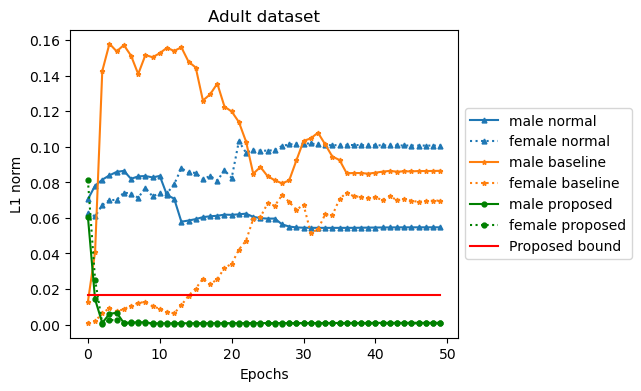

In [12]:
marksize = 3.5
plt.plot(
    np.arange(len(run_fair_dict['male_norm'])),
    run_fair_dict['male_norm'],
    '-^',
    markersize=marksize,
    label='male normal',
    color='#1f77b4'
)

plt.plot(
    np.arange(len(run_fair_dict['female_norm'])),
    run_fair_dict['female_norm'],
    ':^',
    markersize=marksize,
    label='female normal',
    color='#1f77b4'
)

plt.plot(
    np.arange(len(run_alg1_dict['male_norm'])),
    run_alg1_dict['male_norm'],
    '-*',
    markersize=marksize,
    label='male baseline',
    color='#ff7f0e'
)

plt.plot(
    np.arange(len(run_alg1_dict['female_norm'])),
    run_alg1_dict['female_norm'],
    ':*',
    markersize=marksize,
    label='female baseline',
    color='#ff7f0e'
)

plt.plot(
    np.arange(len(run_proposed_dict['male_norm'])),
    run_proposed_dict['male_norm'],
    '-o',
    markersize=marksize,
    label='male proposed',
    color='green'
)

plt.plot(
    np.arange(len(run_proposed_dict['female_norm'])),
    run_proposed_dict['female_norm'],
    ':o',
    markersize=marksize,
    label='female proposed',
    color='green'
)

plt.plot(
    np.arange(len(run_proposed_dict['female_norm'])),
    np.ones(len(run_proposed_dict['female_norm']))*b,
    '-',
    label='Proposed bound',
    color='red'
)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Epochs')
plt.title('Adult dataset')
plt.ylabel('L1 norm')

#ff7f0e
# plt.plot(
#     np.arange(len(run_fair_dict['female_norm'])),
#     np.ones(len(run_fair_dict['female_norm']))*bound,
#     '-o',
#     label='Proposed bound',
#     color='green'

## Bank

In [13]:
noise_scale = [30.0, 11.25, 5.9375, 4.140625, 3.22265625, 1.5673828125, 1.025390625, 0.8477783203125, 0.75531005859375] 
epsilon = [0.1, 0.25, 0.5, 0.75, 1.0, 2.5, 5.0, 7.5, 10.0]

t = [norm.ppf(0.975, loc=0, scale=i*clip) for i in noise_scale]
def bound(t, clip):
    return 0.1*(2*clip+2*t)/2
bd = []
for i, n in enumerate(t):
    bd.append(bound(n, 0.04))

In [42]:
with open('results/dict/bank_fair_fold_0_sigma_3.22265625_C_0.04_24112022_73330.pkl', 'rb') as f:
    run_fair_dict = pickle.load(f)
with open('results/dict/bank_proposed_fold_0_sigma_3.22265625_C_0.04_23112022_18149.pkl', 'rb') as f:
    run_proposed_dict = pickle.load(f)
with open('results/dict/bank_alg1_fold_0_sigma_3.22265625_C_0.04_24112022_73319.pkl', 'rb') as f:
    run_alg1_dict = pickle.load(f)

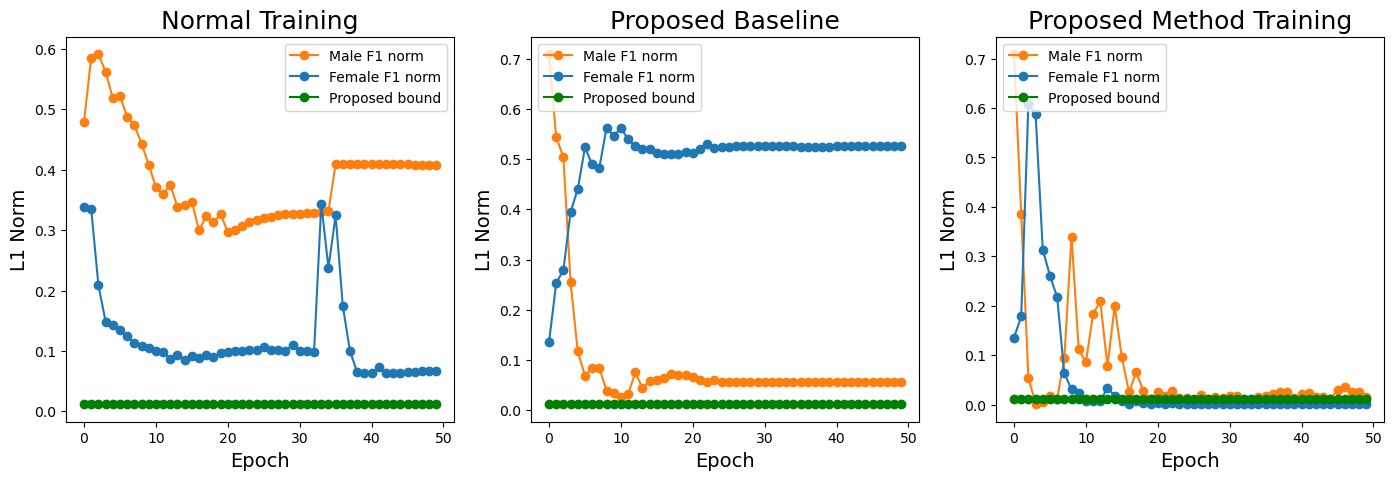

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(17,5))
b = bd[4]
axs[0].plot(
    np.arange(len(run_fair_dict['male_norm'])),
    run_fair_dict['male_norm'],
    '-o',
    label='Male F1 norm',
    color='#ff7f0e'
)

axs[0].plot(
    np.arange(len(run_fair_dict['female_norm'])),
    run_fair_dict['female_norm'],
    '-o',
    label='Female F1 norm',
    color='#1f77b4'
)

axs[0].plot(
    np.arange(len(run_fair_dict['female_norm'])),
    np.ones(len(run_fair_dict['female_norm']))*b,
    '-o',
    label='Proposed bound',
    color='green'
)

axs[0].set_ylabel('L1 Norm', size=14)
axs[0].set_xlabel('Epoch', size=14)
axs[0].set_title(f'Normal Training',size=18)
axs[0].legend()

axs[1].plot(
    np.arange(len(run_alg1_dict['male_norm'])),
    run_alg1_dict['male_norm'],
    '-o',
    label='Male F1 norm',
    color='#ff7f0e'
)

axs[1].plot(
    np.arange(len(run_alg1_dict['female_norm'])),
    run_alg1_dict['female_norm'],
    '-o',
    label='Female F1 norm',
    color='#1f77b4'
)

axs[1].plot(
    np.arange(len(run_alg1_dict['female_norm'])),
    np.ones(len(run_alg1_dict['female_norm']))*b,
    '-o',
    label='Proposed bound',
    color='green'
)

axs[1].set_ylabel('L1 Norm', size=14)
axs[1].set_xlabel('Epoch', size=14)
axs[1].set_title(f'Proposed Baseline',size=18)
axs[1].legend(loc=2)

axs[2].plot(
    np.arange(len(run_proposed_dict['male_norm'])),
    run_proposed_dict['male_norm'],
    '-o',
    label='Male F1 norm',
    color='#ff7f0e'
)

axs[2].plot(
    np.arange(len(run_proposed_dict['female_norm'])),
    run_proposed_dict['female_norm'],
    '-o',
    label='Female F1 norm',
    color='#1f77b4'
)

axs[2].plot(
    np.arange(len(run_proposed_dict['female_norm'])),
    np.ones(len(run_proposed_dict['female_norm']))*b,
    '-o',
    label='Proposed bound',
    color='green'
)

axs[2].set_ylabel('L1 Norm', size=14)
axs[2].set_xlabel('Epoch', size=14)
axs[2].set_title(f'Proposed Method Training',size=18)
axs[2].legend(loc=2)

Text(0, 0.5, 'L1 norm')

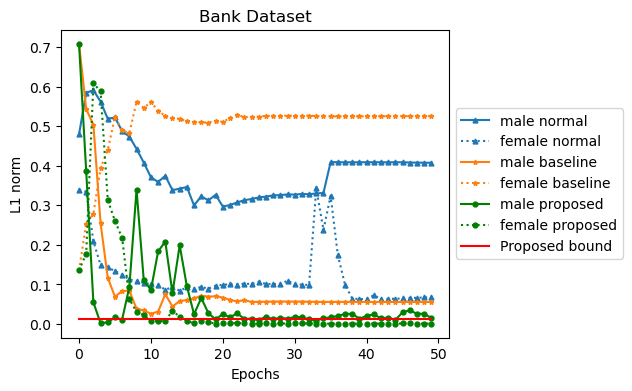

In [45]:
marksize = 3.5
plt.plot(
    np.arange(len(run_fair_dict['male_norm'])),
    run_fair_dict['male_norm'],
    '-^',
    markersize=marksize,
    label='male normal',
    color='#1f77b4'
)

plt.plot(
    np.arange(len(run_fair_dict['female_norm'])),
    run_fair_dict['female_norm'],
    ':^',
    markersize=marksize,
    label='female normal',
    color='#1f77b4'
)

plt.plot(
    np.arange(len(run_alg1_dict['male_norm'])),
    run_alg1_dict['male_norm'],
    '-*',
    markersize=marksize,
    label='male baseline',
    color='#ff7f0e'
)

plt.plot(
    np.arange(len(run_alg1_dict['female_norm'])),
    run_alg1_dict['female_norm'],
    ':*',
    markersize=marksize,
    label='female baseline',
    color='#ff7f0e'
)

plt.plot(
    np.arange(len(run_proposed_dict['male_norm'])),
    run_proposed_dict['male_norm'],
    '-o',
    markersize=marksize,
    label='male proposed',
    color='green'
)

plt.plot(
    np.arange(len(run_proposed_dict['female_norm'])),
    run_proposed_dict['female_norm'],
    ':o',
    markersize=marksize,
    label='female proposed',
    color='green'
)

plt.plot(
    np.arange(len(run_proposed_dict['female_norm'])),
    np.ones(len(run_proposed_dict['female_norm']))*b,
    '-',
    label='Proposed bound',
    color='red'
)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Epochs')
plt.title('Bank Dataset')
plt.ylabel('L1 norm')

#ff7f0e
# plt.plot(
#     np.arange(len(run_fair_dict['female_norm'])),
#     np.ones(len(run_fair_dict['female_norm']))*bound,
#     '-o',
#     label='Proposed bound',
#     color='green'

## Stroke

In [51]:
with open('results/dict/stroke_fair_fold_0_sigma_1.0_C_0.04_23112022_10114.pkl', 'rb') as f:
    run_fair_dict = pickle.load(f)
with open('results/dict/stroke_proposed_fold_0_sigma_1.0_C_0.04_22112022_11713.pkl', 'rb') as f:
    run_proposed_dict = pickle.load(f)
with open('results/dict/stroke_alg1_fold_0_sigma_1.0_C_0.04_23112022_101121.pkl', 'rb') as f:
    run_alg1_dict = pickle.load(f)

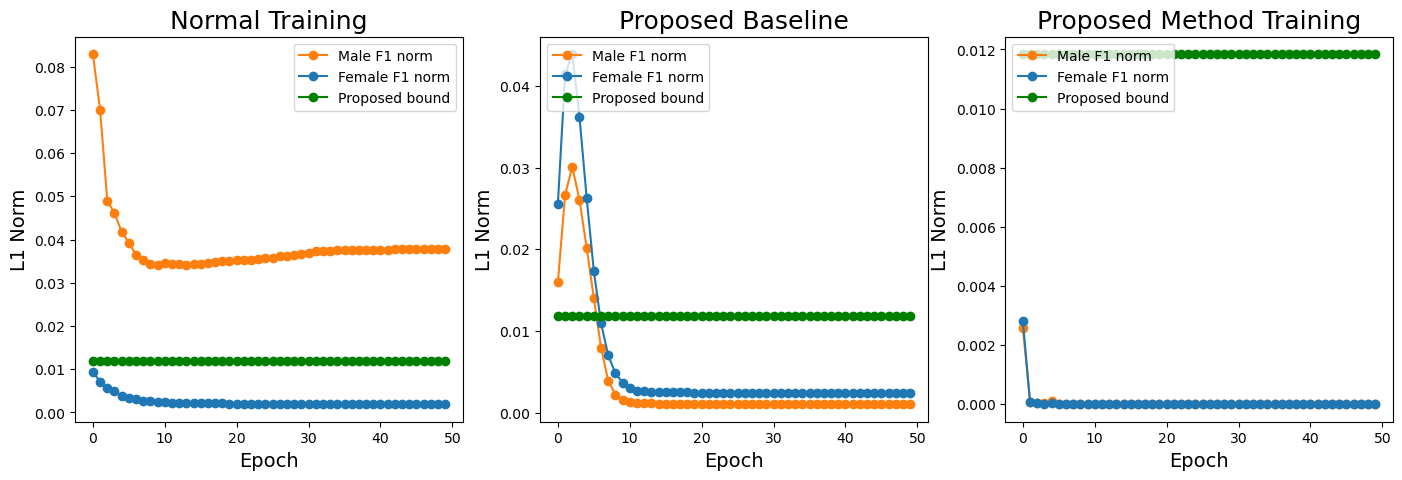

In [52]:
fig, axs = plt.subplots(1, 3, figsize=(17,5))
b = bd[4]
axs[0].plot(
    np.arange(len(run_fair_dict['male_norm'])),
    run_fair_dict['male_norm'],
    '-o',
    label='Male F1 norm',
    color='#ff7f0e'
)

axs[0].plot(
    np.arange(len(run_fair_dict['female_norm'])),
    run_fair_dict['female_norm'],
    '-o',
    label='Female F1 norm',
    color='#1f77b4'
)

axs[0].plot(
    np.arange(len(run_fair_dict['female_norm'])),
    np.ones(len(run_fair_dict['female_norm']))*b,
    '-o',
    label='Proposed bound',
    color='green'
)

axs[0].set_ylabel('L1 Norm', size=14)
axs[0].set_xlabel('Epoch', size=14)
axs[0].set_title(f'Normal Training',size=18)
axs[0].legend()

axs[1].plot(
    np.arange(len(run_alg1_dict['male_norm'])),
    run_alg1_dict['male_norm'],
    '-o',
    label='Male F1 norm',
    color='#ff7f0e'
)

axs[1].plot(
    np.arange(len(run_alg1_dict['female_norm'])),
    run_alg1_dict['female_norm'],
    '-o',
    label='Female F1 norm',
    color='#1f77b4'
)

axs[1].plot(
    np.arange(len(run_alg1_dict['female_norm'])),
    np.ones(len(run_alg1_dict['female_norm']))*b,
    '-o',
    label='Proposed bound',
    color='green'
)

axs[1].set_ylabel('L1 Norm', size=14)
axs[1].set_xlabel('Epoch', size=14)
axs[1].set_title(f'Proposed Baseline',size=18)
axs[1].legend(loc=2)

axs[2].plot(
    np.arange(len(run_proposed_dict['male_norm'])),
    run_proposed_dict['male_norm'],
    '-o',
    label='Male F1 norm',
    color='#ff7f0e'
)

axs[2].plot(
    np.arange(len(run_proposed_dict['female_norm'])),
    run_proposed_dict['female_norm'],
    '-o',
    label='Female F1 norm',
    color='#1f77b4'
)

axs[2].plot(
    np.arange(len(run_proposed_dict['female_norm'])),
    np.ones(len(run_proposed_dict['female_norm']))*b,
    '-o',
    label='Proposed bound',
    color='green'
)

axs[2].set_ylabel('L1 Norm', size=14)
axs[2].set_xlabel('Epoch', size=14)
axs[2].set_title(f'Proposed Method Training',size=18)
axs[2].legend(loc=2)

Text(0, 0.5, 'L1 norm')

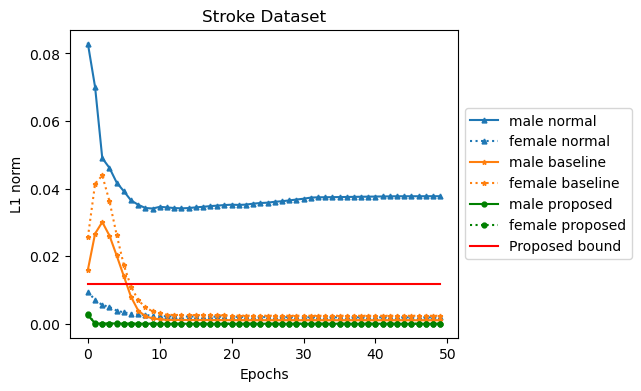

In [53]:
marksize = 3.5
plt.plot(
    np.arange(len(run_fair_dict['male_norm'])),
    run_fair_dict['male_norm'],
    '-^',
    markersize=marksize,
    label='male normal',
    color='#1f77b4'
)

plt.plot(
    np.arange(len(run_fair_dict['female_norm'])),
    run_fair_dict['female_norm'],
    ':^',
    markersize=marksize,
    label='female normal',
    color='#1f77b4'
)

plt.plot(
    np.arange(len(run_alg1_dict['male_norm'])),
    run_alg1_dict['male_norm'],
    '-*',
    markersize=marksize,
    label='male baseline',
    color='#ff7f0e'
)

plt.plot(
    np.arange(len(run_alg1_dict['female_norm'])),
    run_alg1_dict['female_norm'],
    ':*',
    markersize=marksize,
    label='female baseline',
    color='#ff7f0e'
)

plt.plot(
    np.arange(len(run_proposed_dict['male_norm'])),
    run_proposed_dict['male_norm'],
    '-o',
    markersize=marksize,
    label='male proposed',
    color='green'
)

plt.plot(
    np.arange(len(run_proposed_dict['female_norm'])),
    run_proposed_dict['female_norm'],
    ':o',
    markersize=marksize,
    label='female proposed',
    color='green'
)

plt.plot(
    np.arange(len(run_proposed_dict['female_norm'])),
    np.ones(len(run_proposed_dict['female_norm']))*b,
    '-',
    label='Proposed bound',
    color='red'
)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Epochs')
plt.title('Stroke Dataset')
plt.ylabel('L1 norm')

#ff7f0e
# plt.plot(
#     np.arange(len(run_fair_dict['female_norm'])),
#     np.ones(len(run_fair_dict['female_norm']))*bound,
#     '-o',
#     label='Proposed bound',
#     color='green'

# Others

In [13]:
def new_bound(t, clip):
    return 0.1*(2*clip+t)/2
# bound = 0.001*(2*1 + 8*1**2*1**2)/2

In [15]:
# new_bd = []
# for i, n in enumerate(r):
#     new_bd.append(new_bound(n, 0.04))

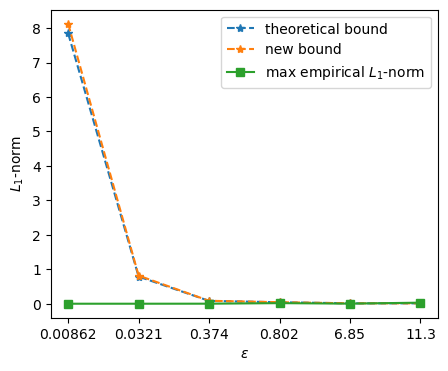

In [36]:
# eps = [0.5, 1.0, 2.0, 5.0]
plt.plot(range(len(epsilon)), bd, '--*', label='theoretical bound')
plt.plot(range(len(epsilon)), new_bd, '--*', label='new bound')
plt.plot(range(len(epsilon)), max_deviation, '-s', label=r'max empirical $L_1$-norm')
plt.ylabel(r'$L_1$-norm')
plt.xlabel(r'$\epsilon$')
plt.xticks(range(len(epsilon)), epsilon)
plt.legend()

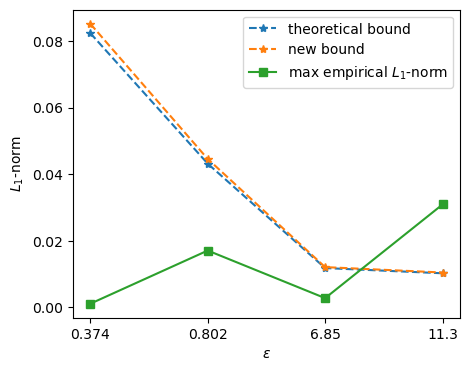

In [37]:
# eps = [0.5, 1.0, 2.0, 5.0]
plt.plot(range(len(epsilon)-2), bd[2:], '--*', label='theoretical bound')
plt.plot(range(len(epsilon)-2), new_bd[2:], '--*', label='new bound')
plt.plot(range(len(epsilon)-2), max_deviation[2:], '-s', label=r'max empirical $L_1$-norm')
plt.ylabel(r'$L_1$-norm')
plt.xlabel(r'$\epsilon$')
plt.xticks(range(len(epsilon)-2), epsilon[2:])
plt.legend()

In [42]:
(0.8067686260057736 + 0.801)/2

0.8038843130028868

In [43]:
performance_ = [0.8031447699772741,
 0.8029605061114182,
 0.8009336035870033,
 0.8028843130028869,
 0.8038843130028868,
 0.8026005773647227]

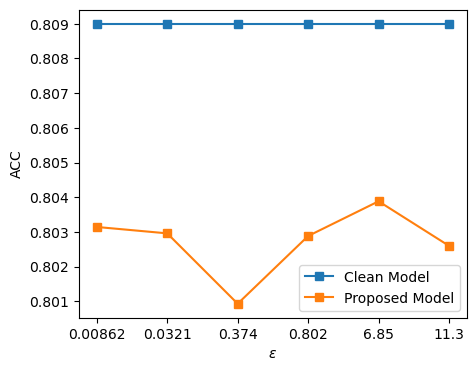

In [44]:
plt.plot(range(len(epsilon)), np.ones(len(epsilon))*0.809, '-s', label=r'Clean Model')
plt.plot(range(len(epsilon)), performance_, '-s', label=r'Proposed Model')
plt.ylabel(r'ACC')
plt.xlabel(r'$\epsilon$')
plt.xticks(range(len(epsilon)), epsilon)
plt.legend()

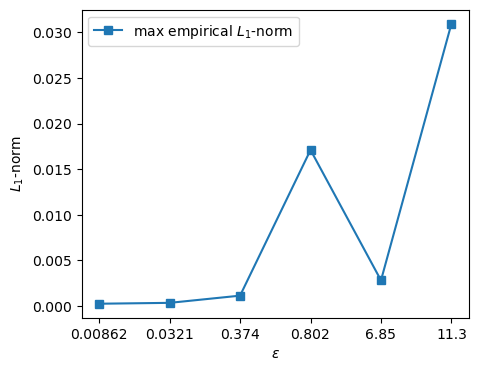

In [21]:
plt.plot(range(len(epsilon)), max_deviation, '-s', label=r'max empirical $L_1$-norm')
plt.ylabel(r'$L_1$-norm')
plt.xlabel(r'$\epsilon$')
plt.xticks(range(len(epsilon)), epsilon)
plt.legend()

In [3]:
with open('results/dict/adult_fair_fold_0_9112022_194819.pkl', 'rb') as f:
    run_fair_dict = pickle.load(f)
with open('results/dict/adult_proposed_fold_0_9112022_195457.pkl', 'rb') as f:
    run_proposed_dict = pickle.load(f)
with open('results/dict/adult_alg1_fold_0_9112022_193928.pkl', 'rb') as f:
    run_alg1_dict = pickle.load(f)

In [4]:
run_fair_dict.keys()

dict_keys(['train_global_history_loss', 'train_male_history_loss', 'train_female_history_loss', 'train_global_history_acc', 'train_male_history_acc', 'train_female_history_acc', 'val_global_history_loss', 'val_male_history_loss', 'val_female_history_loss', 'val_global_history_acc', 'val_male_history_acc', 'val_female_history_acc', 'male_norm', 'female_norm'])

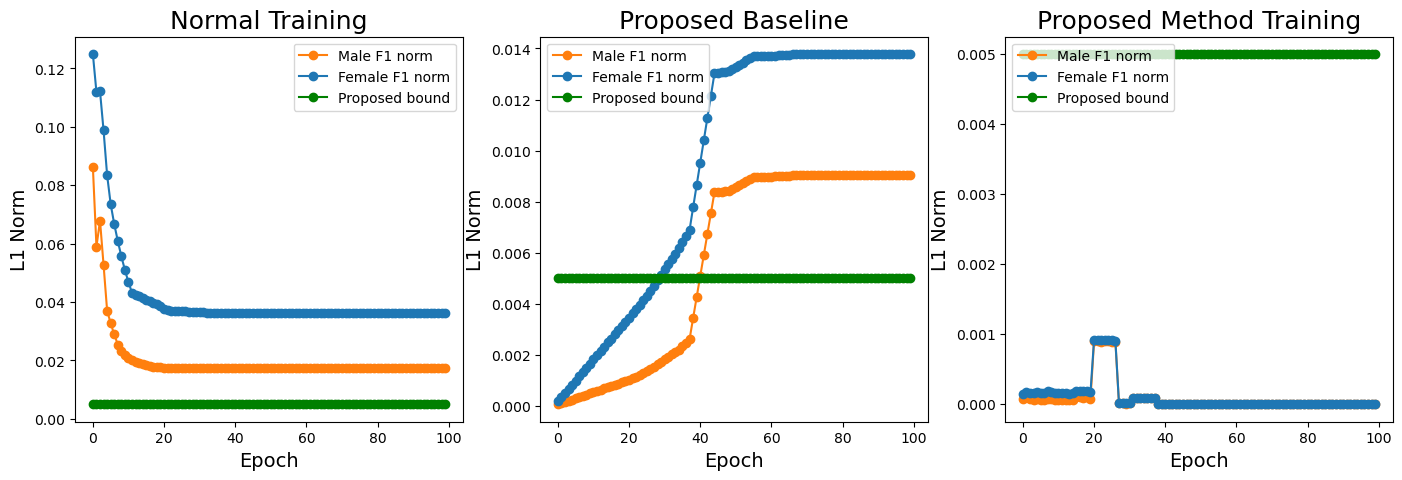

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(17,5))

axs[0].plot(
    np.arange(len(run_fair_dict['male_norm'])),
    run_fair_dict['male_norm'],
    '-o',
    label='Male F1 norm',
    color='#ff7f0e'
)

axs[0].plot(
    np.arange(len(run_fair_dict['female_norm'])),
    run_fair_dict['female_norm'],
    '-o',
    label='Female F1 norm',
    color='#1f77b4'
)

axs[0].plot(
    np.arange(len(run_fair_dict['female_norm'])),
    np.ones(len(run_fair_dict['female_norm']))*bound,
    '-o',
    label='Proposed bound',
    color='green'
)

axs[0].set_ylabel('L1 Norm', size=14)
axs[0].set_xlabel('Epoch', size=14)
axs[0].set_title(f'Normal Training',size=18)
axs[0].legend()

axs[1].plot(
    np.arange(len(run_alg1_dict['male_norm'])),
    run_alg1_dict['male_norm'],
    '-o',
    label='Male F1 norm',
    color='#ff7f0e'
)

axs[1].plot(
    np.arange(len(run_alg1_dict['female_norm'])),
    run_alg1_dict['female_norm'],
    '-o',
    label='Female F1 norm',
    color='#1f77b4'
)

axs[1].plot(
    np.arange(len(run_alg1_dict['female_norm'])),
    np.ones(len(run_alg1_dict['female_norm']))*bound,
    '-o',
    label='Proposed bound',
    color='green'
)

axs[1].set_ylabel('L1 Norm', size=14)
axs[1].set_xlabel('Epoch', size=14)
axs[1].set_title(f'Proposed Baseline',size=18)
axs[1].legend(loc=2)

axs[2].plot(
    np.arange(len(run_proposed_dict['male_norm'])),
    run_proposed_dict['male_norm'],
    '-o',
    label='Male F1 norm',
    color='#ff7f0e'
)

axs[2].plot(
    np.arange(len(run_proposed_dict['female_norm'])),
    run_proposed_dict['female_norm'],
    '-o',
    label='Female F1 norm',
    color='#1f77b4'
)

axs[2].plot(
    np.arange(len(run_proposed_dict['female_norm'])),
    np.ones(len(run_proposed_dict['female_norm']))*bound,
    '-o',
    label='Proposed bound',
    color='green'
)

axs[2].set_ylabel('L1 Norm', size=14)
axs[2].set_xlabel('Epoch', size=14)
axs[2].set_title(f'Proposed Method Training',size=18)
axs[2].legend(loc=2)

Text(0, 0.5, 'L1 norm')

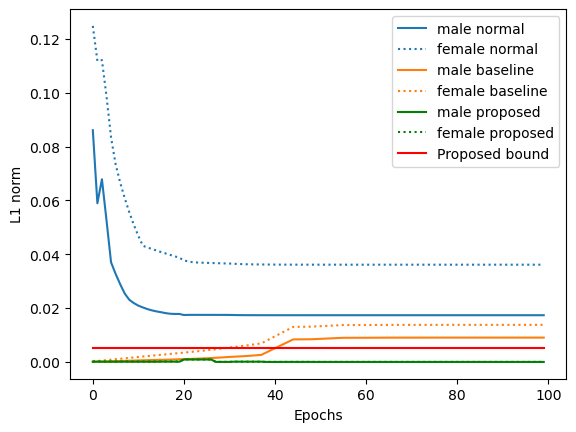

In [17]:
plt.plot(
    np.arange(len(run_fair_dict['male_norm'])),
    run_fair_dict['male_norm'],
    '-',
    label='male normal',
    color='#1f77b4'
)

plt.plot(
    np.arange(len(run_fair_dict['female_norm'])),
    run_fair_dict['female_norm'],
    ':',
    label='female normal',
    color='#1f77b4'
)

plt.plot(
    np.arange(len(run_alg1_dict['male_norm'])),
    run_alg1_dict['male_norm'],
    '-',
    label='male baseline',
    color='#ff7f0e'
)

plt.plot(
    np.arange(len(run_alg1_dict['female_norm'])),
    run_alg1_dict['female_norm'],
    ':',
    label='female baseline',
    color='#ff7f0e'
)

plt.plot(
    np.arange(len(run_proposed_dict['male_norm'])),
    run_proposed_dict['male_norm'],
    '-',
    label='male proposed',
    color='green'
)

plt.plot(
    np.arange(len(run_proposed_dict['female_norm'])),
    run_proposed_dict['female_norm'],
    ':',
    label='female proposed',
    color='green'
)

plt.plot(
    np.arange(len(run_proposed_dict['female_norm'])),
    np.ones(len(run_proposed_dict['female_norm']))*bound,
    '-',
    label='Proposed bound',
    color='red'
)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('L1 norm')

#ff7f0e
# plt.plot(
#     np.arange(len(run_fair_dict['female_norm'])),
#     np.ones(len(run_fair_dict['female_norm']))*bound,
#     '-o',
#     label='Proposed bound',
#     color='green'

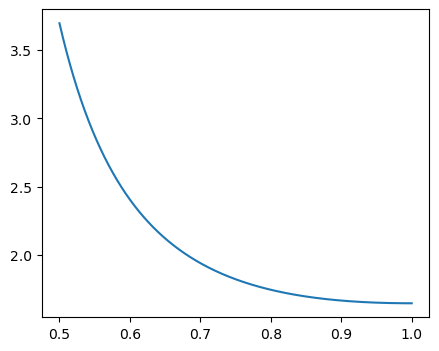

In [38]:
def f(sigma):
    return sigma*np.exp(1/(2*sigma**2))

sig = np.linspace(0.5, 1, 1000)
val = f(sig)
plt.plot(sig, val)